<a href="https://colab.research.google.com/github/MiEmily/DS-Project/blob/main/collaborative_filtering_rec_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
%cd /content/gdrive/MyDrive/Dataset/book_rec


/content/gdrive/MyDrive/Dataset/book_rec


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "minruihu"

In [ ]:
os.environ['KAGGLE_KEY'] = "bd4f3502eea27c943defe3c9a3419ea3"


In [ ]:
!kaggle datasets download -d ruchi798/bookcrossing-dataset


bookcrossing-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
ls

 bookcrossing-dataset.zip  'Books Data with Category Language and Summary'/
'Book reviews'/             kaggle.json


In [ ]:
!unzip bookcrossing-dataset.zip

Archive:  bookcrossing-dataset.zip
  inflating: Book reviews/Book reviews/BX-Book-Ratings.csv  
  inflating: Book reviews/Book reviews/BX-Users.csv  
  inflating: Book reviews/Book reviews/BX_Books.csv  
  inflating: Books Data with Category Language and Summary/Preprocessed_data.csv  






#content filtering-data cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Mounted at /content/gdrive


In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/Dataset/book_rec/Books Data with Category Language and Summary/Preprocessed_data.csv',index_col=[0])
df.index=df.index+1
#index start from 1 instead 0
df.head(5)


In [ ]:
display(df.dtypes,df.shape)

user_id                  int64
location                object
age                    float64
isbn                    object
rating                   int64
book_title              object
book_author             object
year_of_publication    float64
publisher               object
img_s                   object
img_m                   object
img_l                   object
Summary                 object
Language                object
Category                object
city                    object
state                   object
country                 object
dtype: object

(1031175, 18)

In [ ]:
#for content based use, book features.


#keep informative columns of book features
df_books=df[['book_title','book_author','year_of_publication','publisher','Language','Category','Summary']]
#simplified feature name and convert it all lower letter

df_books.columns = map(lambda x: x.lower(), df_books.columns)
df_books.head()



,book_title,book_author,year_of_publication,publisher,language,category,summary
1,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,en,['Social Science'],"Provides an introduction to classical myths placing the addressed\ntopics within their historical context, discussion of archaeological\nevidence as support for mythical events, and how these themes have\nbeen portrayed in literature, art, ..."
2,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York."
3,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York."
4,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York."
5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York."


In [ ]:
len(df_books)

1031175

In [ ]:
df_books.duplicated(subset=['book_title','book_author','year_of_publication','publisher','language','category','summary']).sum()
#drop duplicated book title
df_books=df_books.drop_duplicates(subset=['book_title','book_author','year_of_publication','publisher','language','category','summary'])
len(df_books)

display(df.shape,df_books.shape)

(1031175, 18)

(269482, 7)

In [ ]:
df_books['book_title'].nunique()


241090

In [ ]:

display(df_books.dtypes,df_books.shape)

book_title              object
book_author             object
year_of_publication    float64
publisher               object
language                object
category                object
summary                 object
dtype: object

(269482, 7)

In [ ]:
#convert floar to datetime,  errors set as NaT. mask false, return the out of range records.
out_of_range_dates = df_books.loc[pd.to_datetime(df_books['year_of_publication'], format='%Y', errors='coerce').isnull()]
out_of_range_dates

,book_title,book_author,year_of_publication,publisher,language,category,summary
888721,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378.0,Intisharat-i Quqnus,fa,['Fantasy fiction'],"Mahnaz, the only daughter of a traditional aristocratic family, is\nengaged to her childhood friend Mohammad at the age of 16."
946881,Tasht-i khun,IsmaÂ°il Fasih,1376.0,Nashr-i Alburz,9,9,9


In [ ]:
print(f"before drop out of range_date {df_books.shape}")

before drop out of range_date (269482, 7)


In [ ]:
#dropo out of range_date
df_books=df_books.drop(index=out_of_range_dates.index)
df_books.shape


(269480, 7)

In [ ]:
df_books.dtypes

book_title              object
book_author             object
year_of_publication    float64
publisher               object
language                object
category                object
summary                 object
dtype: object

In [ ]:
#convert float as datetime year.
df_books['year_of_publication'] = pd.to_datetime(df_books['year_of_publication'], format='%Y',).dt.year

df_books.dtypes

book_title             object
book_author            object
year_of_publication     int64
publisher              object
language               object
category               object
summary                object
dtype: object

In [ ]:
pd.set_option('display.max_columns', None)
df_books.head(500)
#as we can see, it exist some nasty values. lets drop all the value as 9

,book_title,book_author,year_of_publication,publisher,language,category,summary
1,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,en,['Social Science'],"Provides an introduction to classical myths placing the addressed\ntopics within their historical context, discussion of archaeological\nevidence as support for mythical events, and how these themes have\nbeen portrayed in literature, art, ..."
2,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,en,['Actresses'],"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York."
16,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,en,['1940-1949'],"Here, for the first time in paperback, is an outstanding military\nhistory that offers a dramatic new perspective on the Allied campaign\nthat began with the invasion of the D-Day beaches of Normandy. Nationa\nadvertising in Military History."
19,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,en,['Medical'],"Describes the great flu epidemic of 1918, an outbreak that killed some\nforty million people worldwide, and discusses the efforts of\nscientists and public health officials to understand and prevent\nanother lethal pandemic"
30,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,en,['Design'],"A look at the incredibly well-preserved ancient mummies found in\nWestern China describes their clothing and appearance, attempts to\nreconstruct their culture, and speculates about how Caucasians could\nhave found their way to the feet of the ..."
31,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,en,['Fiction'],"A Chinese immigrant who is convinced she is dying threatens to\ncelebrate the Chinese New Year by unburdening herself of\neverybody&#39;s hidden truths, thus prompting a series of comic\nmisunderstandings"
64,What If?: The World's Foremost Military Historians Imagine What Might Have Been,Robert Cowley,2000,Berkley Publishing Group,en,['History'],"Essays by respected military historians, including Stephen Ambrose,\nDavid McCullough, James McPherson, and John Keegan, consider the\nconsequences if history had turned out differently, such as if the\nweather on D-Day had been worse or if ..."
69,PLEADING GUILTY,Scott Turow,1993,Audioworks,9,9,9
72,Under the Black Flag: The Romance and the Reality of Life Among the Pirates,David Cordingly,1996,Random House,en,['Fiction'],"An authoritative, revisionist history of the golden age of piracy\ndraws on original archive material and records to provide a realistic\nstudy of pirates and their lives that refutes many of the colorful\nmyths about the era. 35,000 first ..."
73,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,en,['Fiction'],"Now back in print, Ann Beattie&#39;s finest short story collection,\nreissued to accompany the publication of her latest novel, &quot;The\nDoctor&#39;s House."


In [ ]:
#replace invalid row(value as9 )
df_books.replace('9', np.nan)

In [ ]:
df_books[df_books['book_title']=='Man at Work (Avon Light Contemporary Romances)']

In [ ]:
df_books.shape

In [ ]:
df_books=df_books.dropna()

In [ ]:
df_books.shape


In [ ]:
#df_books.head(500)

In [ ]:
df_books=df_books.reset_index(drop=True)
df_books.index=df_books.index+1

In [ ]:
df_books.head(10)

In [ ]:
df_books.to_csv('/content/gdrive/MyDrive/Dataset/book_ct/book_clean.csv',index=False)




# book_clean_content-filtering data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Mounted at /content/gdrive


In [ ]:

cd ..

/content/drive/MyDrive/Dataset


In [ ]:
cd /content/drive/MyDrive


/content/drive/MyDrive


In [ ]:
books_ct=pd.read_csv('/content/gdrive/MyDrive/Dataset/book_ct/book_clean.csv')

In [ ]:
books_ct.head(10)

In [ ]:
books_ct.tail(5)

In [ ]:
books_ct.shape

(269480, 7)

In [ ]:
books_ct.dtypes

book_title          object
author              object
publication_year     int64
publisher           object
language            object
category            object
summary             object
dtype: object

In [ ]:
books_ct.describe(include='all')

# categorical feature explore

In [ ]:
#select the object column
books_categorical=books_ct.select_dtypes(include=['object'])
#drop title and summary.
books_categorical=books_categorical.drop(['book_title','summary'],axis=1)
books_categorical.head()


,book_author,publisher,language,category
0,Mark P. O. Morford,Oxford University Press,en,['Social Science']
1,Richard Bruce Wright,HarperFlamingo Canada,en,['Actresses']
2,Carlo D'Este,HarperPerennial,en,['1940-1949']
3,Gina Bari Kolata,Farrar Straus Giroux,en,['Medical']
4,E. J. W. Barber,W. W. Norton & Company,en,['Design']


In [ ]:
books_categorical.shape


(269480, 4)

In [ ]:
books_ct.shape

(269480, 7)

In [ ]:
unique_count=books_categorical.nunique()

In [ ]:
unique_count.values

array([101592,  16727,     33,   6448])

In [ ]:
unique_count.index

Index(['author', 'publisher', 'language', 'category'], dtype='object')

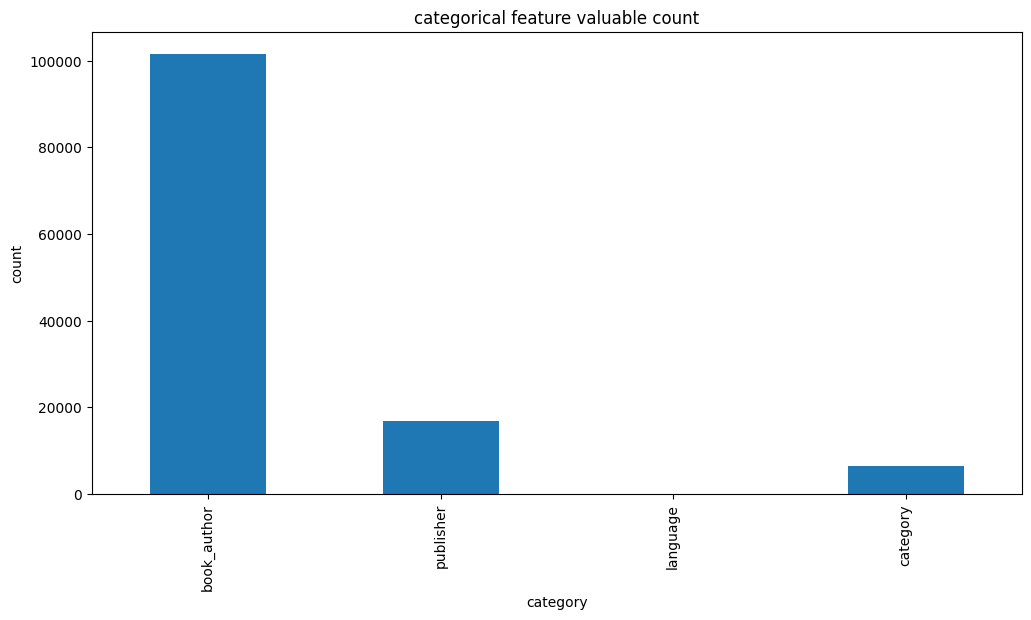

In [ ]:
#show the categorical feature
import matplotlib.pyplot as plt

books_categorical.nunique().plot.bar(figsize=(12,6))
plt.xlabel('category')
plt.ylabel('count')
plt.title('categorical feature valuable count')
plt.show()


# collaborative-data cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [ ]:
cd /content/drive/MyDrive/Dataset/book_cl


[Errno 2] No such file or directory: '/content/drive/MyDrive/Dataset/book_cl'
/


In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [ ]:
book_cl=pd.read_csv('/content/gdrive/MyDrive/Dataset/book_rec/Books Data with Category Language and Summary/Preprocessed_data.csv')
book_cl.index=book_cl.index+1

In [ ]:
books_ct=pd.read_csv('/content/gdrive/MyDrive/Dataset/book_ct/book_clean.csv')


In [ ]:
books_ct.shape

(269480, 7)

In [ ]:
book_cl=book_cl.loc[:,~book_cl.columns.str.contains('^Unnamed')]

In [ ]:
#for user-item matrix


#keep informative columns of
book_cl=book_cl[['user_id','book_title','rating']]


In [ ]:
book_cl.dtypes

user_id        int64
book_title    object
rating         int64
dtype: object

In [ ]:
book_cl.shape

(1031175, 3)

In [ ]:
#check missing value
book_cl.isnull().sum()

user_id       0
book_title    0
rating        0
dtype: int64

In [ ]:
#check duplicate rows
book_cl.duplicated(subset=['user_id','book_title']).sum()
#drop all the duplicated rows, keep the first occurrence
book_cl=book_cl.drop_duplicates(subset=['user_id','book_title'],keep='first')

In [ ]:
book_cl.shape

(1026397, 3)

In [ ]:
book_cl.head(10)


,user_id,book_title,rating
1,2,Classical Mythology,0
2,8,Clara Callan,5
3,11400,Clara Callan,0
4,11676,Clara Callan,8
5,41385,Clara Callan,0
6,67544,Clara Callan,8
7,85526,Clara Callan,0
8,96054,Clara Callan,0
9,116866,Clara Callan,9
10,123629,Clara Callan,9


#collaborative  Visualization--for filtering data

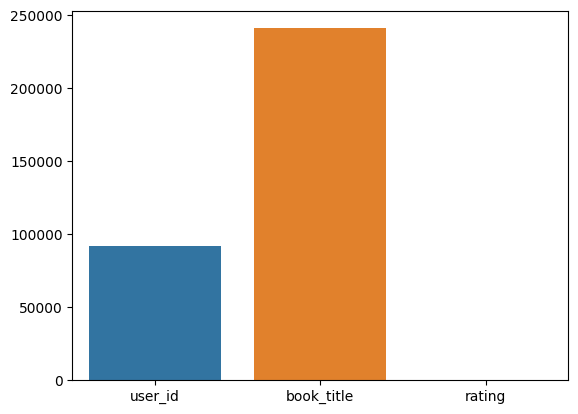

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x=book_cl.columns,y=book_cl.nunique())
plt.show()

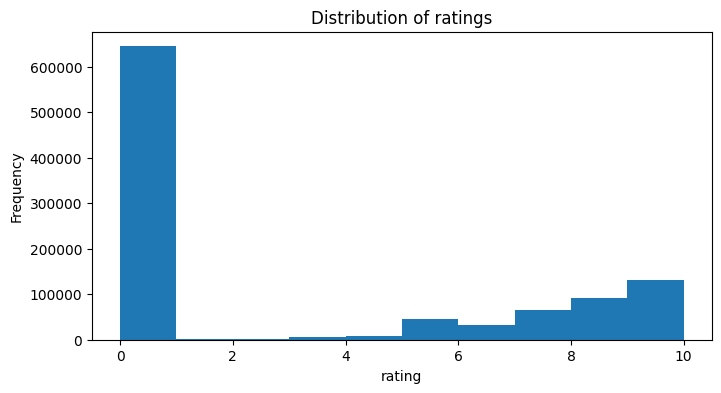

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1,figsize=(8,4))
ax=book_cl['rating'].plot.hist()
ax.set_xlabel('rating')
ax.set_title('Distribution of ratings')
plt.show()

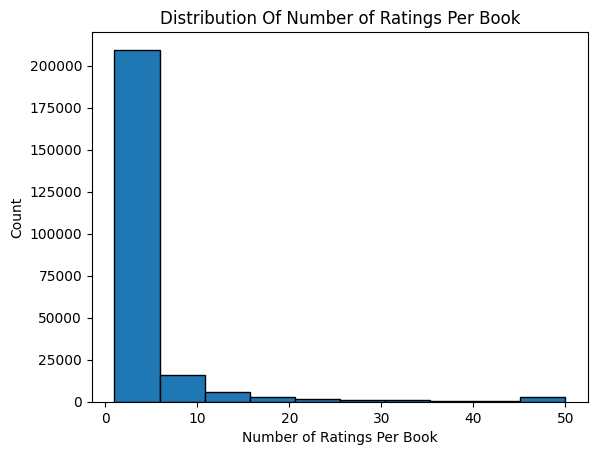

In [ ]:
#max number of rating up to 50
import matplotlib.pyplot as plt

book_ratings = book_cl.groupby('book_title')['rating'].count().clip(upper=50)

plt.hist(book_ratings, bins=10, edgecolor='k')
plt.title('Distribution Of Number of Ratings Per Book')
plt.xlabel('Number of Ratings Per Book')
plt.ylabel('Count')
plt.show()


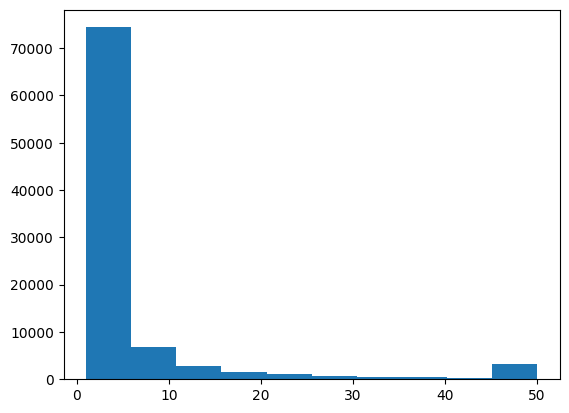

In [ ]:
#max of rating up to 50
import matplotlib.pyplot as plt

user_ratings=book_cl.groupby('user_id')['rating'].count().clip(upper=50)
plt.hist(user_ratings)
plt.show()



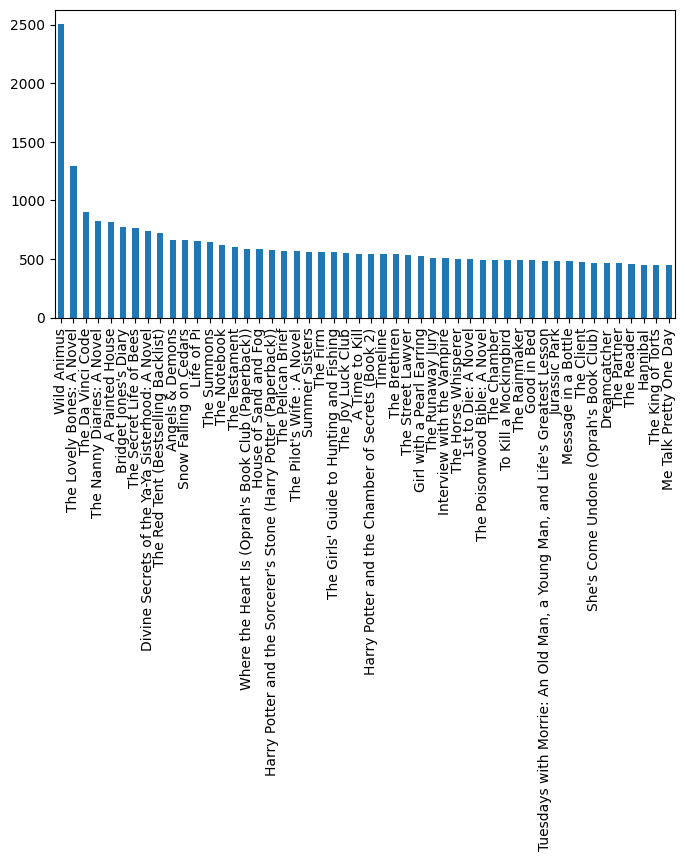

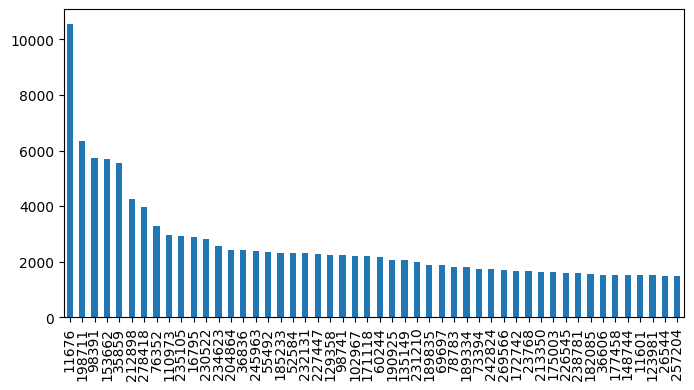

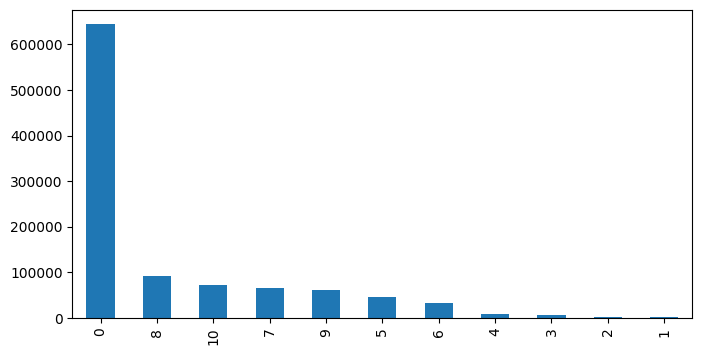

In [ ]:
plt.figure(1,figsize=(8,4))
book_cl['book_title'].value_counts()[:50].plot(kind='bar')
plt.show()
plt.figure(1,figsize=(8,4))
book_cl['user_id'].value_counts()[:50].plot(kind='bar')
plt.show()
plt.figure(1,figsize=(8,4))
book_cl['rating'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
#filtered books that at least have 50 ratings records
min_book_ratings=100
filter_books=book_cl['book_title'].value_counts()>min_book_ratings
filter_books=filter_books[filter_books].index.tolist()
#filter users that at least have 50 ratings records
min_user_ratings=100
filter_users=book_cl['user_id'].value_counts()>min_user_ratings
filter_users=filter_users[filter_users].index.tolist()


In [ ]:
#filter records that user rating and moive rating at least 100 rating records
filtered_book_cl=book_cl[book_cl['book_title'].isin(filter_books)&(book_cl['user_id'].isin(filter_users))]

In [ ]:
book_cl.shape

(1026397, 3)

In [ ]:
filtered_book_cl.shape

(84457, 3)

In [ ]:
filtered_book_cl.isnull().sum()

user_id       0
book_title    0
rating        0
dtype: int64

In [ ]:
filtered_book_cl.shape

(84457, 3)

In [ ]:
#book content data that unique books
valid_books=books_ct['book_title'].unique()
#ratings that users and book at least have 50 rating records, and also books can be found in book_content table
ct_valid_cl=filtered_book_cl[filtered_book_cl['book_title'].isin(valid_books)]
#decrease from filtered_book_cl--167943,3 to now 124173
ct_valid_cl.shape

(84457, 3)

In [ ]:
ct_valid_cl.nunique(axis=0)

user_id       1623
book_title     890
rating          11
dtype: int64

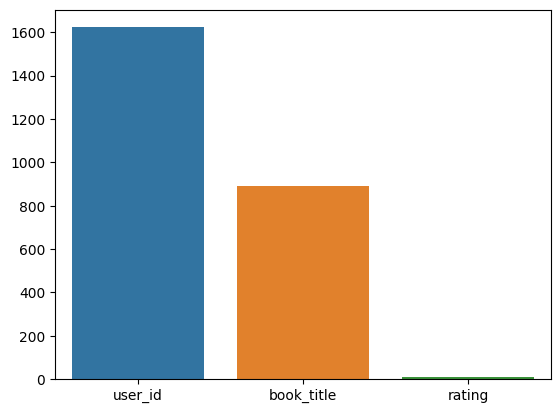

In [ ]:
sns.barplot(x=ct_valid_cl.columns,y=ct_valid_cl.nunique())
plt.show()

In [ ]:
# ct_valid_cl.to_csv('/content/gdrive/MyDrive/Dataset/book_cl/ct_valid_cl.csv',index=False)
# filtered_book_cl.to_csv('/content/gdrive/MyDrive/Dataset/book_cl/book_cl_clean.csv',index=False)

# Recommender_input_data


In [ ]:
import pandas as pd

In [ ]:
filtered_book_cl=pd.read_csv('/content/gdrive/MyDrive/Dataset/book_cl/book_cl_clean.csv',)

In [ ]:
filtered_book_cl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84457 entries, 32 to 1029895
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     84457 non-null  int64 
 1   book_title  84457 non-null  object
 2   rating      84457 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.6+ MB


In [ ]:
filtered_book_cl.nunique(axis=0)

user_id       1623
book_title     890
rating          11
dtype: int64

In [343]:
#book dataframe
books_ct=pd.read_csv('/content/gdrive/MyDrive/Dataset/book_ct/book_clean.csv')

In [ ]:
books_ct.head(100)

In [347]:
books_ct.shape


(269480, 7)

In [ ]:
ct_valid_cl=pd.read_csv('/content/gdrive/MyDrive/Dataset/book_cl/ct_valid_cl.csv')

In [ ]:
ct_valid_cl.shape

(84457, 3)

In [ ]:
filtered_book_ct=books_ct[books_ct['book_title'].isin(ct_valid_cl['book_title'].unique())]
filtered_book_ct.head(5)

,book_title,book_author,year_of_publication,publisher,language,category,summary
5,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,en,['Fiction'],"A Chinese immigrant who is convinced she is dying threatens to\ncelebrate the Chinese New Year by unburdening herself of\neverybody&#39;s hidden truths, thus prompting a series of comic\nmisunderstandings"
18,The Testament,John Grisham,1999,Dell,en,['Fiction'],"A suicidal billionaire, a burnt-out Washington litigator, and a woman\nwho has forsaken technology to work in the wilds of Brazil are all\nbrought together by an astounding mystery of the testament"
19,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume,en,['Fiction'],"Staring unflinchingly into the abyss of slavery, this novel transforms\nhistory into a story as powerful as Exodus and as intimate as a\nlullaby."
26,Wild Animus,Rich Shapero,2004,Too Far,en,['Fiction'],"Wild animus is a search for the primordial, a test of human\nfoundations and a journey to the breaking point."
27,Airframe,Michael Crichton,1997,Ballantine Books,en,['Fiction'],"A fatal mid-air collision involving a commercial airliner prompts a\nfrantic, desperate investigation into the causes of the accident, in a\nthriller exploring the issue of safety and security in the aircraft\nindustry"


In [ ]:
filtered_book_ct.loc[filtered_book_ct['category']==9]

,book_title,book_author,year_of_publication,publisher,language,category,summary


In [ ]:
books_ct.isna().sum()

book_title             0
book_author            0
year_of_publication    0
publisher              0
language               0
category               0
summary                0
dtype: int64

In [ ]:
books_ct.head(5)

In [ ]:
#same book user rating more than 1 time.
filtered_book_cl.duplicated(subset=['user_id','book_title']).sum()

0

In [ ]:
filtered_book_cl.shape

(84457, 3)

In [ ]:
ct_valid_cl.shape

(84457, 3)

In [ ]:
ct_valid_cl['book_title'].nunique()

890

In [ ]:
ct_valid_cl['user_id'].nunique()

1623

In [ ]:
df_cl.head(5)

,user_id,book_title,rating
0,11676,The Kitchen God's Wife,9
1,29526,The Kitchen God's Wife,9
2,36836,The Kitchen God's Wife,0
3,46398,The Kitchen God's Wife,9
4,113270,The Kitchen God's Wife,0


#SURPRISE SET UP

In [ ]:
pwd

'/content/drive/MyDrive/Dataset/book_cl'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Mounted at /content/gdrive


In [3]:
pip install surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163487 sha256=a0bd0b04ebe1e277d60512d32b4e9b5854e51246d3f519731754d74f20254446
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
# from surprise import accuracy, Dataset, SVD
# from surprise.model_selection import KFold
# from surprise.reader import Reader
# ct_valid_cl=pd.read_csv('/content/gdrive/MyDrive/Dataset/book_cl/ct_valid_cl.csv')
# reader = Reader(rating_scale=(1, 10))
# data = Dataset.load_from_df(ct_valid_cl[['user_id', 'book_title', 'rating']], reader=reader)

#Stage1: SURPRISE-SVD

In [4]:
raw_ratings=pd.read_csv('/content/gdrive/MyDrive/Dataset/book_cl/ct_valid_cl.csv')
raw_ratings.head(5)

,user_id,book_title,rating
0,11676,The Kitchen God's Wife,9
1,29526,The Kitchen God's Wife,9
2,36836,The Kitchen God's Wife,0
3,46398,The Kitchen God's Wife,9
4,113270,The Kitchen God's Wife,0


In [5]:
new_ratings=raw_ratings.copy()
user_id_mapping={id:i for i,id in enumerate(raw_ratings['user_id'].unique())}
book_title_mapping={id:i for i,id in enumerate(raw_ratings['book_title'].unique())}
new_ratings['user_id']=raw_ratings['user_id'].map(user_id_mapping)
new_ratings['book_id']=raw_ratings['book_title'].map(book_title_mapping)
new_ratings.head(5)

,user_id,book_title,rating,book_id
0,0,The Kitchen God's Wife,9,0
1,1,The Kitchen God's Wife,9,0
2,2,The Kitchen God's Wife,0,0
3,3,The Kitchen God's Wife,9,0
4,4,The Kitchen God's Wife,0,0


In [9]:
print(len(user_id_mapping),len(book_title_mapping),len(new_ratings))

1623 890 84457


In [116]:
#SURPRISE
#In SURPRISE the dataset load convert original data mapping into sequencial for user id and book_title to book_id
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import KFold, train_test_split
from surprise.reader import Reader
import random

reader=Reader(rating_scale=(1,10))
data=Dataset.load_from_df(new_ratings[['user_id','book_id','rating']],reader=reader)
#split train and test data
trainset,testset=train_test_split(data,test_size=0.2,random_state=42)
# random.seed(42)
svd=SVD(random_state=42)
svd.fit(trainset)
#predict and evaluate
svd_predictions=svd.test(testset)
accuracy.rmse(svd_predictions,verbose=True)



RMSE: 3.5224


3.5223640004731114

In [ ]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
import random


# Load data
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(new_ratings[['user_id', 'book_id', 'rating']], reader)

# Split data into training and temporary sets
trainset, tempset = train_test_split(data, test_size=0.2,random_state=42)

# Convert tempset into a list of tuples
tempset_raw_ratings = [(uid, iid, rating) for (uid, iid, rating) in tempset]

# Shuffle tempset ratings
random.shuffle(tempset_raw_ratings)

# Split tempset into validation and test sets
random.seed(42)
halfway_point = int(len(tempset_raw_ratings) * 0.5)
valset_raw_ratings = tempset_raw_ratings[:halfway_point]
testset_raw_ratings = tempset_raw_ratings[halfway_point:]

# Train SVD model
svd = SVD(random_state=42)
svd.fit(trainset)
#prediction
svd_predictions=svd.test(testset_raw_ratings)
# Evaluate model on the test set
test_rmse = accuracy.rmse(svd_predictions, verbose=True)


In [20]:
trainset.n_ratings


67565

In [ ]:
# print(len(valset_raw_ratings),len(testset_raw_ratings))

8446 8446


In [ ]:
print(len(testset))

16892


In [ ]:
# # Extracting data for validation set
# val_user_data = [uid for (uid, iid, rating) in valset_raw_ratings]
# val_book_data = [iid for (uid, iid, rating) in valset_raw_ratings]
# val_ratings = [rating for (uid, iid, rating) in valset_raw_ratings]

# # Generate SVD predictions for validation set
# val_svd_predictions = [svd.predict(uid, iid).est for uid, iid in zip(val_user_data, val_book_data)]
# val_svd_predictions_array = np.array(val_svd_predictions)

# # Convert lists to numpy arrays for validation set
# val_user_data_array = np.array(val_user_data)
# val_book_data_array = np.array(val_book_data)
# val_ratings_array = np.array(val_ratings)
# print(len(val_user_data_array),len(val_book_data_array),len(val_ratings_array),len(val_svd_predictions_array))

8446 8446 8446 8446


In [357]:
# val_svd_predictions_array





#  svd-->ncf

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras-vis

In [ ]:
!pip install tensorflow

In [11]:
# books=pd.read_csv('/content/gdrive/MyDrive/Dataset/book_ct/book_clean.csv')
# # books.head(5)
# dropindice=books[(books['category']=='9')|(books['summary']=='9')].index
# books=books.drop(dropindice)
# books.head(100)

In [21]:

# Extract training data from trainset, and convert the inner data back to input data format
train_user_data = []
train_book_data = []
train_ratings = []

for uid, iid, rating in trainset.all_ratings():
    train_user_data.append(trainset.to_raw_uid(uid))
    train_book_data.append(trainset.to_raw_iid(iid))  # This is now the book ID
    train_ratings.append(rating)

# Convert lists to numpy arrays
train_user_data_array = np.array(train_user_data)
train_book_data_array = np.array(train_book_data)
train_ratings_array = np.array(train_ratings)

# Generate SVD predictions for training data
train_svd_predictions = [svd.predict(uid, iid).est for uid, iid in zip(train_user_data, train_book_data)]
train_svd_predictions_array= np.array(train_svd_predictions)
# train_svd_preds
print(len(train_user_data_array),len(train_book_data_array),len(train_ratings_array),len(train_svd_predictions_array))

67565 67565 67565 67565


In [358]:
# NCF Model Parameters
#https://calvinfeng.gitbook.io/machine-learning-notebook/supervised-learning/recommender/neural_collaborative_filtering
from keras.models import Model,Sequential
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate,Dropout,BatchNormalization,Lambda
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.utils import model_to_dot
from IPython.display import SVG
#user_unique1623 books_unique.890
n_users = len(user_id_mapping)
n_books = len(book_title_mapping)
n_factors = 5  # Number of latent factors

# User and Book Input Layers
user_input = Input(shape=(1,))
book_input = Input(shape=(1,))
svd_input = Input(shape=(1,))

#MLP Embedding[embedding+Flatten]
# Embedding layers+Flatten the embeddings
book_embedding_mlp = Embedding(n_books+1, n_factors,name='book_embedding_mlp')(book_input)
book_vec_mlp = Flatten(name='flatten_book_mlp')(book_embedding_mlp)
user_embedding_mlp = Embedding(n_users+1, n_factors,name='user_embedding_mlp')(user_input)
user_vec_mlp = Flatten(name='flatten_user_mlp')(user_embedding_mlp)
#MF embedding
book_embedding_mf = Embedding(n_books+1, n_factors,name='book_embedding_mf')(book_input)
book_vec_mf = Flatten(name='flatten_book_mf')(book_embedding_mf)
user_embedding_mf=Embedding(n_users+1,n_factors,name='user_embedding_mf')(user_input)
user_vec_mf=Flatten(name='faltten_user_mf')(user_embedding_mf)
# Concatenate the embeddings with SVD prediction
concat = Concatenate()([user_vec_mlp, book_vec_mlp, svd_input])
concat_dropout=Dropout(0.2)(concat)
# MLP layers
dense1 = Dense(64,name='dense1', activation='relu')(concat_dropout)
dense1_bn=BatchNormalization(name='batch_norm_1')(dense1)
dense1_dropout=Dropout(0.2)(dense1_bn)
dense2=Dense(32,name='dense2',activation='relu')(dense1_dropout)
dense2_bn=BatchNormalization(name='batch_norm_2')(dense2)
dense2_dropout=Dropout(0.2)(dense2_bn)
#prediction from both layers
pred_mlp=Dense(16,name='pred_mlp',activation='relu')(dense2_dropout)
pred_mf =Dot(axes=1, name='pred_mf')([book_vec_mf, user_vec_mf])
combine_mlp_mf = Concatenate(name='combine_mlp_mf')([pred_mf, pred_mlp])
#find prediction
result=Dense(1,name='result',activation='sigmoid')(combine_mlp_mf)
result=Lambda(lambda x:x*9+1)(result)

from keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Create and compile the model
ncf_svd = Model(inputs=[user_input, book_input, svd_input], outputs=result)

ncf_svd.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error', metrics=[rmse])

# SVG(model_to_dot(model,show_shapes=True).create(prog='dot',format='svg'))

In [315]:
# Fit the SVD_NCF model
history=ncf_svd.fit([train_user_data_array, train_book_data_array,
                     train_svd_predictions_array], train_ratings_array, epochs=10, batch_size=50)
                    # ,validation_split=0.2)


Epoch 1/10
1352/1352 [==============================] - 4s 3ms/step - loss: 2.3566 - rmse: 1.5027
Epoch 2/10
1352/1352 [==============================] - 4s 3ms/step - loss: 2.3091 - rmse: 1.4894
Epoch 3/10
1352/1352 [==============================] - 4s 3ms/step - loss: 2.3507 - rmse: 1.5004
Epoch 4/10
1352/1352 [==============================] - 4s 3ms/step - loss: 2.3612 - rmse: 1.5056
Epoch 5/10
1352/1352 [==============================] - 4s 3ms/step - loss: 2.3348 - rmse: 1.4984
Epoch 6/10
1352/1352 [==============================] - 4s 3ms/step - loss: 2.3280 - rmse: 1.4951
Epoch 7/10
1352/1352 [==============================] - 4s 3ms/step - loss: 2.3536 - rmse: 1.5023
Epoch 8/10
1352/1352 [==============================] - 4s 3ms/step - loss: 2.3696 - rmse: 1.5087
Epoch 9/10
1352/1352 [==============================] - 4s 3ms/step - loss: 2.3095 - rmse: 1.4889
Epoch 10/10
1352/1352 [==============================] - 4s 3ms/step - loss: 2.3380 - rmse: 1.4979


In [ ]:
history.history

{'loss': [4.460954666137695,
  3.3797147274017334,
  3.1733827590942383,
  3.080332040786743,
  3.0200464725494385],
 'rmse': [2.0194568634033203,
  1.7981643676757812,
  1.7402955293655396,
  1.7143535614013672,
  1.7003506422042847]}

In [ ]:
# #data split into trainset, testset,valset
# # Generate SVD predictions on the testset
# test_user_data = [uid for (uid, iid, rating) in testset_raw_ratings]
# test_book_data = [iid for (uid, iid, rating) in testset_raw_ratings]
# test_ratings = [rating for (uid, iid, rating) in testset_raw_ratings]
# test_svd_predictions = svd.test(testset_raw_ratings)
# test_svd_pred_rating=[pred.est for pred in test_svd_predictions]
# # test_svd_preds = np.array([pred.est for pred in test_svd_predictions])
# print(type(test_user_data),type(test_book_data),type(test_ratings))
# # Ensure all input arrays are NumPy arrays
# test_user_data_array = np.array(test_user_data)
# test_book_data_array = np.array(test_book_data)
# # test_svd_preds_array = np.array(test_svd_preds)
# test_ratings_array = np.array(test_ratings)
# test_svd_predictions_array = np.array(test_svd_pred_rating)

# # evaluate ncf_svd
# test_loss = ncf_svd.evaluate([test_user_data_array, test_book_data_array, test_svd_predictions_array], test_ratings_array)
# print(len(test_user_data_array),len(test_book_data_array),len(test_ratings_array),len(test_svd_predictions_array))
# #batch_size=8.  2112/2112 [==============================] - 4s 2ms/step - loss: 15.9119

<class 'list'> <class 'list'> <class 'list'>
264/264 [==============================] - 1s 2ms/step - loss: 13.0082 - rmse: 3.5701
8446 8446 8446 8446


In [285]:
# data split into trainset and testset

test_user_data = [uid for (uid, iid, rating) in testset]
test_book_data = [iid for (uid, iid, rating) in testset]
test_ratings = [rating for (uid, iid, rating) in testset]
test_svd_predictions = svd.test(testset)
test_svd_pred_rating=[pred.est for pred in test_svd_predictions]
# test_svd_preds = np.array([pred.est for pred in test_svd_predictions])
print(type(test_user_data),type(test_book_data),type(test_ratings))
# Ensure all input arrays are NumPy arrays
test_user_data_array0 = np.array(test_user_data)
test_book_data_array0 = np.array(test_book_data)
# test_svd_preds_array = np.array(test_svd_preds)
test_ratings_array0 = np.array(test_ratings)
test_svd_preds_array0 = np.array(test_svd_pred_rating)


<class 'list'> <class 'list'> <class 'list'>
528/528 [==============================] - 1s 2ms/step - loss: 13.0830 - rmse: 3.5779


In [316]:

# test_loss
test_loss = ncf_svd.evaluate([test_user_data_array0, test_book_data_array0, test_svd_preds_array0], test_ratings_array0)

528/528 [==============================] - 1s 2ms/step - loss: 13.7702 - rmse: 3.6655


In [ ]:
len(test_ratings_array0)

In [96]:
ncf_svd_pred=ncf_svd.predict([test_user_data_array0, test_book_data_array0, test_svd_preds_array0])
max(ncf_svd_pred)

528/528 [==============================] - 1s 2ms/step


array([9.322086], dtype=float32)

In [ ]:
# ncf_svd_pred=ncf_svd.predict([test_user_data_array, test_book_data_array, test_svd_predictions_array])
# max(ncf_svd_pred)

#ncf

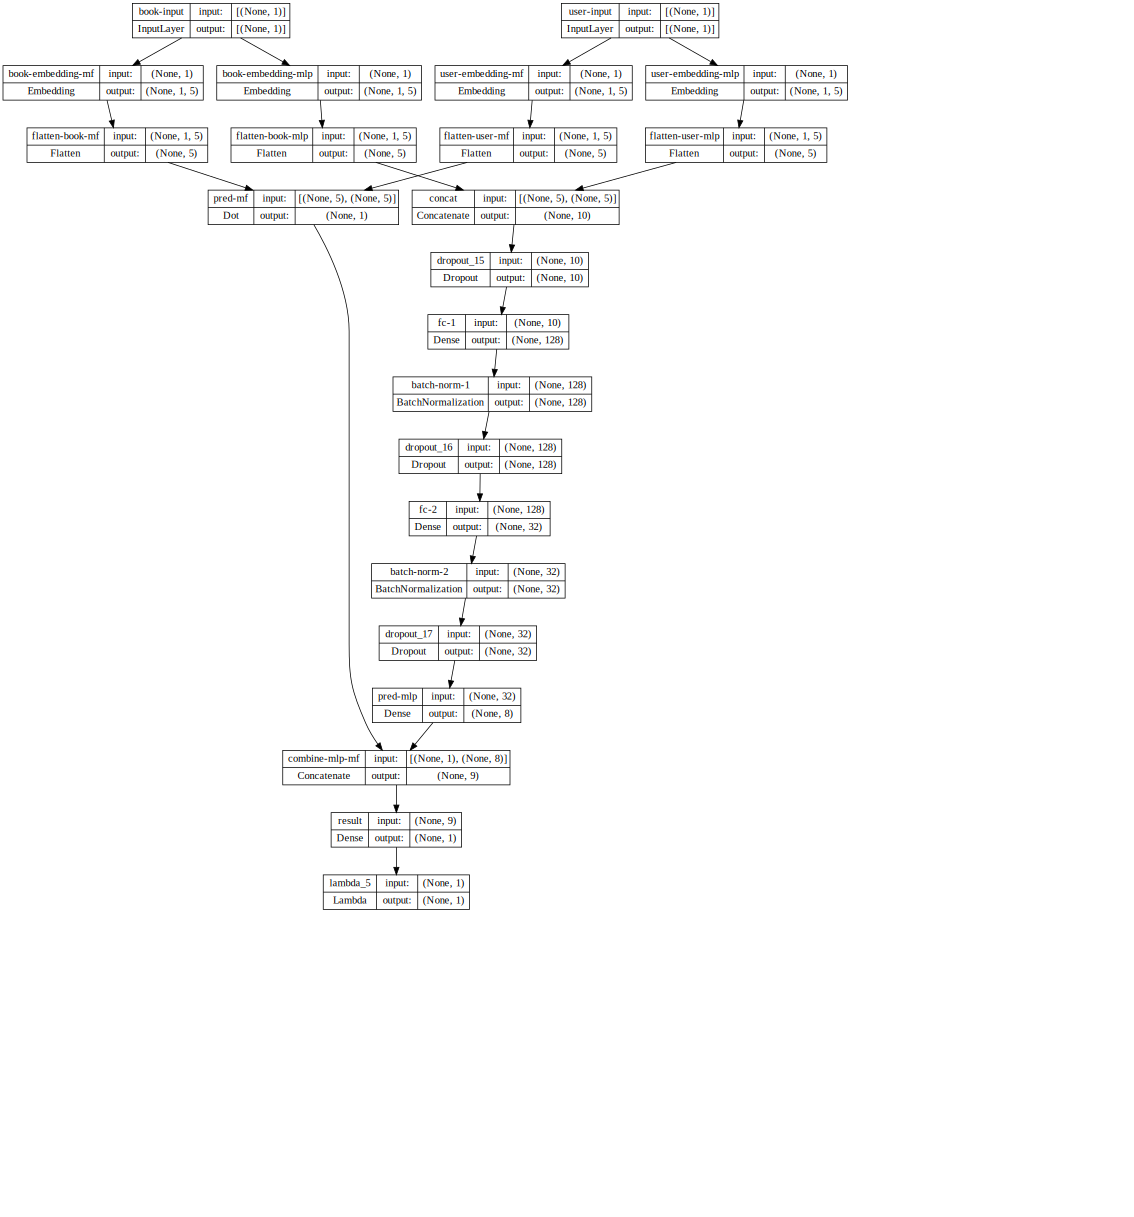

In [145]:
from keras.models import Model,Sequential
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate,Dropout,BatchNormalization,Lambda
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.utils import model_to_dot
from IPython.display import SVG
from keras import backend as K


num_books = len(book_title_mapping)
num_users = len(user_id_mapping)
#tune parameter dimenstion
num_factors = 5

# Define inputs
book_input = Input(shape=[1], name='book-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
book_embedding_mlp = Embedding(num_books + 1, num_factors, name='book-embedding-mlp')(book_input)
book_vec_mlp = Flatten(name='flatten-book-mlp')(book_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, num_factors, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
book_embedding_mf = Embedding(num_books + 1, num_factors, name='book-embedding-mf')(book_input)
book_vec_mf = Flatten(name='flatten-book-mf')(book_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, num_factors, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = Concatenate(name='concat')([book_vec_mlp, user_vec_mlp])
concat_dropout = Dropout(0.2)(concat)
layer1 = Dense(128, activation='relu', name='fc-1')(concat_dropout)
layer1_bn = BatchNormalization(name='batch-norm-1')(layer1)
layer1_dropout = Dropout(0.2)(layer1_bn)
layer2 = Dense(32, activation='relu', name='fc-2')(layer1_dropout)
layer2_bn = BatchNormalization(name='batch-norm-2')(layer2)
layer2_dropout = Dropout(0.2)(layer2_bn)
# layer3 = Dense(16, activation='relu', name='layer3')(layer2_dropout)
# layer4 = Dense(8, activation='relu', name='layer4')(layer3)

# Prediction from MLP
pred_mlp = Dense(8, activation='relu', name='pred-mlp')(layer2_dropout)
# Prediction from GMF
pred_mf = Dot(axes=1, name='pred-mf')([book_vec_mf, user_vec_mf])
# Combine MLP and MF predictions
combine_mlp_mf = Concatenate(name='combine-mlp-mf')([pred_mf, pred_mlp])
# Final prediction layer
result = Dense(1, activation='sigmoid', name='result')(combine_mlp_mf)
# Scale output to range 1-10
result = Lambda(lambda x: x * 9 + 1)(result)
from keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
# Compile the model
ncf = Model(inputs=[user_input, book_input], outputs=result)
ncf.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',metrics=[rmse])
# ncf.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
#rmse

# Display the model architecture
SVG(model_to_dot(ncf, show_shapes=True).create(prog='dot', format='svg'))


In [275]:
# Fit the NCF model
history=ncf.fit([train_user_data_array, train_book_data_array], train_ratings_array, epochs=5, batch_size=180)

Epoch 1/5
376/376 [==============================] - 2s 4ms/step - loss: 5.6188 - rmse: 2.3616
Epoch 2/5
376/376 [==============================] - 2s 4ms/step - loss: 5.5291 - rmse: 2.3419
Epoch 3/5
376/376 [==============================] - 1s 4ms/step - loss: 5.5757 - rmse: 2.3529
Epoch 4/5
376/376 [==============================] - 1s 4ms/step - loss: 5.5563 - rmse: 2.3482
Epoch 5/5
376/376 [==============================] - 2s 4ms/step - loss: 5.5196 - rmse: 2.3398


In [280]:
# test ncf
ncf_test_loss = ncf.evaluate([test_user_data_array0, test_book_data_array0], test_ratings_array0)

3379/3379 [==============================] - 6s 2ms/step - loss: 16.5422 - rmse: 3.7336


In [266]:
ncf_predictions=ncf.predict([test_user_data_array0,test_book_data_array0])
max(ncf_predictions)

528/528 [==============================] - 1s 2ms/step


array([10.], dtype=float32)

In [ ]:
# test ncf
# ncf_test_loss = ncf.evaluate([test_user_data_array, test_book_data_array], test_ratings_array)

264/264 [==============================] - 1s 2ms/step - loss: 11.5321 - rmse: 3.3710


In [ ]:
# ncf_predictions= ncf.predict([test_user_data_array,test_book_data_array])

264/264 [==============================] - 1s 2ms/step


In [ ]:
# ncf_pred=ncf_predictions.flatten().tolist()

# max(ncf_pred)

9.935325622558594

In [ ]:
# print(len(test_book_data),len(test_user_data),len(test_ratings_array),len(ncf_predictions))

#ncf tuning


In [28]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.3 MB/s eta 0:00:00


In [29]:
from keras_tuner import HyperModel
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Concatenate, Dropout, Dense, BatchNormalization,Lambda
from keras.optimizers import Adam
from keras.utils import model_to_dot
from IPython.display import SVG

class NCFHyperModel(HyperModel):
    def __init__(self, num_users, num_books):
        self.num_users = num_users
        self.num_books = num_books

    def build(self, hp):
        # User and Book Input Layers
        user_input = Input(shape=(1,))
        book_input = Input(shape=(1,))

        # Hyperparameters
        num_factors = hp.Int('num_factors', min_value=5, max_value=50, step=5)
        first_dense_units = hp.Int('first_dense_units', min_value=64, max_value=128, step=16)
        second_dense_units = hp.Int('second_dense_units', min_value=32, max_value=64, step=16)
        third_dense_units=hp.Int('third_dense_units',min_value=16,max_value=32,step=16)
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # MLP Embeddings
        # (Use num_factors as the embedding dimension)


        book_embedding_mlp = Embedding(num_books + 1, num_factors, name='book-embedding-mlp')(book_input)
        book_vec_mlp = Flatten(name='flatten-book-mlp')(book_embedding_mlp)

        user_embedding_mlp = Embedding(num_users + 1, num_factors, name='user-embedding-mlp')(user_input)
        user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

        # MF Embeddings
        book_embedding_mf = Embedding(num_books + 1, num_factors, name='book-embedding-mf')(book_input)
        book_vec_mf = Flatten(name='flatten-book-mf')(book_embedding_mf)

        user_embedding_mf = Embedding(num_users + 1, num_factors, name='user-embedding-mf')(user_input)
        user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

        # MLP layers
        concat = Concatenate(name='concat')([book_vec_mlp, user_vec_mlp])
        concat_dropout = Dropout(0.2)(concat)
        fc_1 = Dense(first_dense_units, activation='relu', name='fc-1')(concat_dropout)
        fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
        fc_1_dropout = Dropout(0.2)(fc_1_bn)
        fc_2 = Dense(second_dense_units, activation='relu', name='fc-2')(fc_1_dropout)
        fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
        fc_2_dropout = Dropout(0.2)(fc_2_bn)

        # Prediction from MLP
        pred_mlp = Dense(third_dense_units, activation='relu', name='pred-mlp')(fc_2_dropout)

        # Prediction from MF
        pred_mf = Dot(axes=1, name='pred-mf')([book_vec_mf, user_vec_mf])

        # Combine MLP and MF predictions
        combine_mlp_mf = Concatenate(name='combine-mlp-mf')([pred_mf, pred_mlp])

        # Final prediction layer
        result = Dense(1, activation='sigmoid', name='result')(combine_mlp_mf)
        result= Lambda(lambda x:x*9+1)(result)



        # Compile model
        model = Model(inputs=[user_input, book_input], outputs=result)
        model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error', metrics=[rmse])
        # Print model summary for each trial
        # model.summary()



        return model


def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [ ]:
# from keras_tuner import RandomSearch


# num_users = len(user_id_mapping)
# num_books = len(book_title_mapping)

# hypermodel = NCFHyperModel(num_users=num_users, num_books=num_books)
# tuner = RandomSearch(
#     hypermodel,
#     objective='val_loss',
#     max_trials=10,
#     executions_per_trial=2,
#     directory='hyperparam_tuning',
#     project_name='tuning'
# )
# tuner.search([train_user_data_array, train_book_data_array], train_ratings_array,
#             epochs=10,
#             validation_data=([val_user_data_array, val_book_data_array], val_ratings_array))
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# best_model = hypermodel.build(best_hps)
# history = best_model.fit([train_user_data_array, train_book_data_array],train_ratings_array,epochs=10,  validation_data=([val_user_data_array, val_book_data_array], val_ratings_array))
# # Predict on test set
# tuning_test_predictions = best_model.predict([test_user_data_array, test_book_data_array])

# # Calculate RMSE
# tuning_test_rmse = rmse(test_ratings_array, tuning_test_predictions)
# print("Test RMSE: ", K.eval(tuning_test_rmse),'Max estimate rating: ',max(tuning_test_predictions))




Trial 10 Complete [00h 03m 06s]
val_loss: 11.37894868850708

Best val_loss So Far: 11.37894868850708
Total elapsed time: 00h 32m 17s
Epoch 1/10
2112/2112 [==============================] - 11s 4ms/step - loss: 15.8083 - rmse: 3.9493 - val_loss: 13.4596 - val_rmse: 3.6451
Epoch 2/10
2112/2112 [==============================] - 8s 4ms/step - loss: 13.3127 - rmse: 3.6249 - val_loss: 12.8502 - val_rmse: 3.5592
Epoch 3/10
2112/2112 [==============================] - 9s 4ms/step - loss: 12.6659 - rmse: 3.5357 - val_loss: 12.1826 - val_rmse: 3.4652
Epoch 4/10
2112/2112 [==============================] - 9s 4ms/step - loss: 11.9772 - rmse: 3.4348 - val_loss: 11.7957 - val_rmse: 3.4084
Epoch 5/10
2112/2112 [==============================] - 9s 4ms/step - loss: 11.5662 - rmse: 3.3735 - val_loss: 11.5994 - val_rmse: 3.3789
Epoch 6/10
2112/2112 [==============================] - 9s 4ms/step - loss: 11.3279 - rmse: 3.3395 - val_loss: 11.5057 - val_rmse: 3.3658
Epoch 7/10
2112/2112 [================

In [50]:
from keras_tuner import RandomSearch

num_users = len(user_id_mapping)
num_books = len(book_title_mapping)

hypermodel = NCFHyperModel(num_users=num_users, num_books=num_books)
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='ncf_tuning_nv',
    project_name='ncf_tuning_nv',

)

Reloading Tuner from ncf_tuning_nv/ncf_tuning_nv/tuner0.json


In [49]:
tuner.search(x=[train_user_data_array, train_book_data_array], y=train_ratings_array,
             epochs=10,validation_split=0.2)

Trial 10 Complete [00h 01m 07s]
val_loss: 15.155377388000488

Best val_loss So Far: 15.086986541748047
Total elapsed time: 00h 18m 42s


In [ ]:
# ncf_tuner.search([train_user_data_array, train_book_data_array], train_ratings_array,
#              epochs=10,

#              validation_data=([val_user_data_array, val_book_data_array], val_ratings_array))


In [51]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [277]:
best_model = hypermodel.build(best_hps)
history = best_model.fit([train_user_data_array, train_book_data_array],train_ratings_array,epochs=5,batch_size=180)



Epoch 1/5
376/376 [==============================] - 4s 4ms/step - loss: 14.0197 - rmse: 3.7292
Epoch 2/5
376/376 [==============================] - 2s 4ms/step - loss: 12.0232 - rmse: 3.4644
Epoch 3/5
376/376 [==============================] - 2s 4ms/step - loss: 11.5705 - rmse: 3.3975
Epoch 4/5
376/376 [==============================] - 2s 4ms/step - loss: 11.1183 - rmse: 3.3291
Epoch 5/5
376/376 [==============================] - 2s 4ms/step - loss: 10.6431 - rmse: 3.2577


In [178]:
# # testset(val) ncf
# ncf_tune_test_loss = best_model.evaluate([test_user_data_array, test_book_data_array], test_ratings_array)

In [282]:
# test ncf
ncf_tune_test_loss = best_model.evaluate([test_user_data_array0, test_book_data_array0], test_ratings_array0)

528/528 [==============================] - 1s 2ms/step - loss: 11.5916 - rmse: 3.3804


In [ ]:
# Predict on test set
# ncf_tuning_test_predictions = ncf_best_model.predict([test_user_data_array, test_book_data_array])



264/264 [==============================] - 1s 2ms/step


In [131]:
# Predict on test set
ncf_tuning_predictions = best_model.predict([test_user_data_array0, test_book_data_array0])


528/528 [==============================] - 1s 2ms/step


In [132]:
max(ncf_tuning_predictions)

array([9.892958], dtype=float32)

In [56]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the best hyperparameters
print("Best Hyperparameters:")
print(f"Num Factors: {best_hps.get('num_factors')}")
print(f"First Dense Units: {best_hps.get('first_dense_units')}")
print(f"Second Dense Units: {best_hps.get('second_dense_units')}")
print(f"Third Dense Units: {best_hps.get('third_dense_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")


Best Hyperparameters:
Num Factors: 5
First Dense Units: 112
Second Dense Units: 64
Third Dense Units: 16
Dropout Rate: 0.30000000000000004
Learning Rate: 0.001


# svd-->ncf tuning

In [ ]:
import tensorflow as tf
import kerastuner as kt


<ipython-input-210-09b8a9a0d621>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [97]:
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout, BatchNormalization,Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras_tuner import HyperModel
from keras import backend as K


class SVDNCFHyperModel(HyperModel):
    def __init__(self, num_users, num_books):
        self.num_users = num_users
        self.num_books = num_books


    def build(self, hp):
        # User and Book Input Layers
        user_input = Input(shape=(1,))
        book_input = Input(shape=(1,))
        svd_input = Input(shape=(1,))

        # Hyperparameters
        n_factors = hp.Int('n_factors', min_value=5, max_value=50, step=5)
        first_dense_units = hp.Int('first_dense_units', min_value=64, max_value=128, step=16)
        second_dense_units = hp.Int('second_dense_units', min_value=32, max_value=64, step=16)
        third_dense_units=hp.Int('third_dense_units',min_value=16,max_value=32,step=16)
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)


        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


        # MLP Embeddings
        book_embedding_mlp = Embedding(num_books + 1, num_factors, name='book-embedding-mlp')(book_input)
        book_vec_mlp = Flatten(name='flatten-book-mlp')(book_embedding_mlp)

        user_embedding_mlp = Embedding(num_users + 1, num_factors, name='user-embedding-mlp')(user_input)
        user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

        # MF Embeddings
        book_embedding_mf = Embedding(num_books + 1, num_factors, name='book-embedding-mf')(book_input)
        book_vec_mf = Flatten(name='flatten-book-mf')(book_embedding_mf)

        user_embedding_mf = Embedding(num_users + 1, num_factors, name='user-embedding-mf')(user_input)
        user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

        # MLP layers
        concat = Concatenate(name='concat')([book_vec_mlp, user_vec_mlp])
        concat_dropout = Dropout(0.2)(concat)
        fc_1 = Dense(first_dense_units, activation='relu', name='fc-1')(concat_dropout)
        fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
        fc_1_dropout = Dropout(0.2)(fc_1_bn)
        fc_2 = Dense(second_dense_units, activation='relu', name='fc-2')(fc_1_dropout)
        fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
        fc_2_dropout = Dropout(0.2)(fc_2_bn)

        # Prediction from MLP
        pred_mlp = Dense(third_dense_units, activation='relu', name='pred-mlp')(fc_2_dropout)

        # Prediction from MF
        pred_mf = Dot(axes=1, name='pred-mf')([book_vec_mf, user_vec_mf])

        # Combine MLP and MF predictions
        combine_mlp_mf = Concatenate(name='combine-mlp-mf')([pred_mf, pred_mlp])

        # Final prediction layer
        result = Dense(1, activation='sigmoid', name='result')(combine_mlp_mf)
        result=Lambda(lambda x:x*9+1)(result)


           # Compile model
        model = Model(inputs=[user_input, book_input, svd_input], outputs=result)
        model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error', metrics=[rmse])

        return model

    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))






In [98]:
# Instantiate the hypermodel

num_users = len(user_id_mapping)
num_books = len(book_title_mapping)
svd_ncf_hypermodel = SVDNCFHyperModel(num_users=num_users, num_books=num_books)

In [99]:
from keras_tuner import RandomSearch

svd_ncf_tuner = RandomSearch(
    svd_ncf_hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='svd_ncf_tuning',
    project_name='svd_ncf_tuning',
)



In [100]:
svd_ncf_tuner.search([train_user_data_array, train_book_data_array, train_svd_predictions_array], train_ratings_array,
             epochs=10,validation_split=0.2)

Trial 10 Complete [00h 01m 03s]
val_loss: 15.160341262817383

Best val_loss So Far: 15.112982749938965
Total elapsed time: 00h 10m 51s


In [ ]:
# svd_ncf_tuner.search([train_user_data_array, train_book_data_array, train_svd_predictions_array], train_ratings_array,
#              epochs=10,
#              validation_data=([val_user_data_array, val_book_data_array, val_svd_predictions_array], val_ratings_array))



In [317]:
# Get the best hyperparameters
svd_ncf_best_hps = svd_ncf_tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
svd_ncf_best_model = svd_ncf_hypermodel.build(svd_ncf_best_hps)


In [326]:
history = svd_ncf_best_model.fit([train_user_data_array, train_book_data_array, train_svd_predictions_array],
                         train_ratings_array,
                         epochs=5,batch_size=20)  # Or another number of epochs that you find suitable


Epoch 1/5
3379/3379 [==============================] - 10s 3ms/step - loss: 8.2584 - rmse: 2.8053
Epoch 2/5
3379/3379 [==============================] - 10s 3ms/step - loss: 7.9481 - rmse: 2.7521
Epoch 3/5
3379/3379 [==============================] - 10s 3ms/step - loss: 7.8276 - rmse: 2.7273
Epoch 4/5
3379/3379 [==============================] - 10s 3ms/step - loss: 7.6865 - rmse: 2.7042
Epoch 5/5
3379/3379 [==============================] - 10s 3ms/step - loss: 7.6652 - rmse: 2.6977


In [ ]:
# history = svd_ncf_best_model.fit([train_user_data_array, train_book_data_array, train_svd_predictions_array],
#                          train_ratings_array,
#                          epochs=10,  # Or another number of epochs that you find suitable
#                          validation_data=([val_user_data_array, val_book_data_array, val_svd_predictions_array], val_ratings_array))


In [356]:
svd_ncf_tune_test_loss = svd_ncf_best_model.evaluate([test_user_data_array0, test_book_data_array0, test_svd_preds_array0], test_ratings_array0)

528/528 [==============================] - 1s 2ms/step - loss: 14.8995 - rmse: 3.8214


In [ ]:
# svd_ncf_tune_test_loss = svd_ncf_best_model.evaluate([test_user_data_array, test_book_data_array, test_svd_predictions_array], test_ratings_array)

In [ ]:
svd_ncf_tune_test_predictions=svd_ncf_best_model.predict([test_user_data_array0, test_book_data_array0, test_svd_preds_array0])


In [ ]:
# svd_ncf_tune_test_predictions=svd_ncf_best_model.predict([test_user_data_array, test_book_data_array, test_svd_predictions_array])


In [325]:
max(svd_ncf_tune_test_predictions)

array([9.95473], dtype=float32)

# svd+ncf/2

In [107]:
len(svd_predictions)

16892

In [335]:
svd_predictions=svd.test(testset)
svd_pred=[pred.est for pred in svd_predictions]
svd_pred
len(svd_pred)

16892

In [334]:
max(svd_pred)

10

In [333]:
ncf_pred= ncf.predict([test_user_data_array0,test_book_data_array0])
len(ncf_pred)

528/528 [==============================] - 1s 2ms/step


16892

In [332]:
max(ncf_pred)

array([9.97618], dtype=float32)

In [331]:
def combined_prediction(n, s):

    # Simple average of both predictions
    # Assuming ncf_pred and svd_pred are your lists
    average_pred = [(n + s) / 2 for n, s in zip(ncf_pred, svd_pred)]

    return average_pred

In [330]:
combined_pred_rating = combined_prediction(ncf_pred,svd_pred)
# print(type(ncf_pred),type(svd_pred))
combined_pred_rating
len(combined_pred_rating)

16892

In [ ]:
ncf_tuning_predictions

In [328]:
#tuning svd, tuning ncf
svd_best_predictions=svd_best.test(testset)
svd_best_predictions=[pred.est for pred in svd_best_predictions]
#ncf tuning
ncf_tuning_test_predictions = best_model.predict([test_user_data_array0, test_book_data_array0])
combined_pred_rating = combined_prediction(ncf_tuning_predictions,svd_best_predictions)
# print(type(ncf_pred),type(svd_pred))
combined_pred_rating
len(combined_pred_rating)

528/528 [==============================] - 1s 2ms/step


16892

In [329]:
from sklearn.metrics import mean_squared_error
import math
y_actual = test_ratings_array0
y_predicted = combined_pred_rating

MSE = mean_squared_error(y_actual, y_predicted)

RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

3.4013307158470916


#Models CV without tuning

In [ ]:
# SURPRISE MODEL FOR PREDICTION
def base_model_cv(model,data):
# define a cross-validation iterator
  kf = KFold(n_splits=5)
  rmse_values=[]
  # algo = SVD()

  for trainset, testset in kf.split(data):

      # train and test algorithm.
      model.fit(trainset)
      predictions = model.test(testset)

      # Compute and print Root Mean Squared Error
      rmse=accuracy.rmse(predictions,verbose=False)
      rmse_values.append(rmse)
  return rmse_values



In [ ]:
new_ratings.describe(include='all')

,user_id,book_title,rating,book_id
count,84457.000000,84457,84457.000000,84457.000000
unique,NaN,890,NaN,NaN
top,NaN,Wild Animus,NaN,NaN
freq,NaN,555,NaN,NaN
mean,604.659910,NaN,2.215186,396.574517
std,431.508835,NaN,3.680972,257.332403
min,0.000000,NaN,0.000000,0.000000
25%,207.000000,NaN,0.000000,168.000000
50%,574.000000,NaN,0.000000,377.000000
75%,936.000000,NaN,5.000000,616.000000


In [ ]:
from surprise import SVD,NMF,SlopeOne,CoClustering

model_cv=pd.DataFrame()
cl_algs=[SVD(),NMF(),SlopeOne(),CoClustering()]
column_names = ['svd', 'nmf', 'slopeone', 'coclustering']
for alg,column in zip(cl_algs,column_names):
  model_cv[column]=  base_model_cv(alg,data)
model_cv.index=model_cv.index+1
model_cv.loc[6] = model_cv.mean(axis=0)
model_cv = model_cv.rename(index={6: 'avg_rmse'})


model_cv

,svd,nmf,slopeone,coclustering
1,3.519290,3.717315,3.385923,3.406455
2,3.534493,3.716000,3.364583,3.413882
3,3.538511,3.707892,3.360792,3.401373
4,3.537013,3.706417,3.380239,3.413435
5,3.498356,3.771315,3.355515,3.399572
avg_rmse,3.525533,3.723788,3.369410,3.406943


svd             3.507499
nmf             3.811661
slopeone        3.383313
coclustering    3.424451
Name: avg_rmse, dtype: float64

AttributeError: ignored

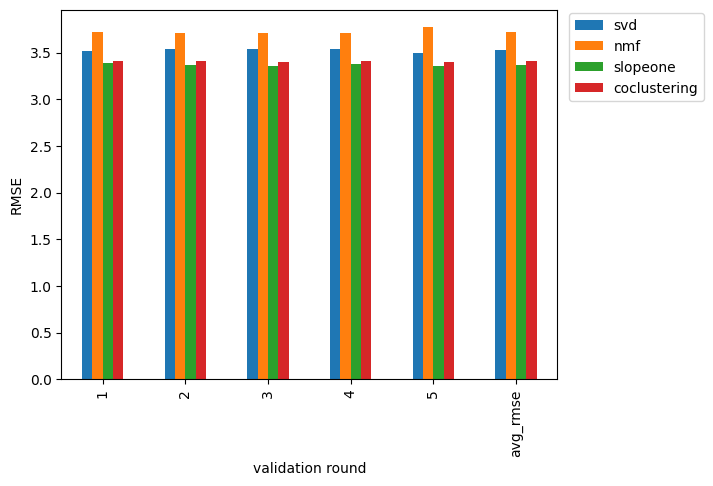

In [ ]:
import plotly as plt
import plotly.graph_objs as go
ax=model_cv.plot.bar()
ax.legend(bbox_to_anchor=(1.01,1.01))
ax.set_xlabel('validation round')
ax.set_ylabel('RMSE')
plt.show()

# model svd with Tune hyps


In [121]:
import os
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import Dataset, Reader, SVD,NMF,SlopeOne,CoClustering
from surprise.model_selection import cross_validate
import pandas as pd

In [122]:


def tune_hps(model,data,parameters):
  grid_search=GridSearchCV(model,param_grid=parameters,measures=["rmse"],cv=5)
  grid_search.fit(data)
  best_params = grid_search.best_params['rmse']
  # display(grid_search.best_score,grid_search.best_params)
  best_model=model(**best_params)
  return best_model
def best_model_evaluate(best_model,data):
  trainset, testset = train_test_split(data, test_size=0.2,random_state=42)
  best_predictions=best_model.fit(trainset).test(testset)
  best_cv_results = cross_validate(best_model, data, measures=['RMSE'], cv=5, verbose=True)
  # avg_rmse=sum(best_cv_results['test_rmse']) / len(best_cv_results['test_rmse'])
  # print( "Average RMSE:",avg_rmse)
  return best_cv_results


In [123]:
#svd model
parameters = {"n_factors": [10,20,30],
               "reg_all": [0.04,0.06],
               "n_epochs":[10,20,30],
               "lr_all":[.002,.005,.01]}
svd_best=tune_hps(SVD,data,parameters)
svd_best_evaluate=best_model_evaluate(svd_best,data)


Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.3422  3.3777  3.3610  3.3672  3.3224  3.3541  0.0196  
Fit time          0.62    0.64    0.68    0.67    0.67    0.65    0.02    
Test time         0.09    0.09    0.09    0.10    0.10    0.10    0.00    


In [128]:
svd_best_pred=svd_best.test(testset)


In [ ]:
#nmf model
nmf_parameters = {
    'n_factors': [10, 20, 30],
    'n_epochs': [25, 100, 200],
    'reg_pu': [0.02, 0.04, 0.06],
    'reg_qi': [0.02, 0.04, 0.06],
    'init_low': [0.01, 0.02, 0.03],
    'init_high': [0.1, 0.2, 0.3],
}


nmf_best=tune_hps(NMF,data,nmf_parameters)
nmf_best_evaluate=best_model_evaluate(nmf_best,data)


In [ ]:
#coclustering
coc_parameters = {
    'n_cltr_u':[1,5,10],
    'n_cltr_i':[1,5,10],
    'n_epochs':[50,100,200],
}


coc_best=tune_hps(CoClustering,data,coc_parameters)
coc_best_evaluate=best_model_evaluate(coc_best,data)

Evaluating RMSE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.3977  3.3708  3.3720  3.3568  3.3411  3.3677  0.0187  
Fit time          1.88    1.92    1.93    1.93    1.92    1.91    0.02    
Test time         0.05    0.05    0.19    0.05    0.05    0.08    0.06    
Average RMSE: 3.3677150236987465


#tuned vs no tuned visualization(avg)

In [ ]:
ntuned_rmse=model_cv.loc['avg_rmse']
ntuned_rmse

svd             3.507499
nmf             3.811661
slopeone        3.383313
coclustering    3.424451
Name: avg_rmse, dtype: float64

In [ ]:
# rmse=[svd_best_evaluate,nmf_best_evaluate,,coc_best_evaluate]
# slopone_best_evaluate=model_cv['slopeone']
t={
    'svd':svd_best_evaluate['test_rmse'],
    'nmf':nmf_best_evaluate['test_rmse'],
    'coclustering':coc_best_evaluate['test_rmse']
}
tuned_model_rmse=pd.DataFrame(t)
# # tuned_model_rmse['avg_rmse']=tuned_model_rmse.mean(axis=0)
# # tuned_model_rmse.rename(index={6:'avg_rmse'})
tuned_model_rmse.index=tuned_model_rmse.index+1
tuned_model_rmse.loc[6]=tuned_model_rmse.mean(axis=0)
tuned_model_rmse=tuned_model_rmse.rename(index={6:'avg_rmse'})
tuned_model_rmse.insert(2,column='slopeone',value=model_cv['slopeone'])
tuned_model_rmse


,svd,nmf,slopeone,coclustering
1,3.373694,3.765025,3.393504,3.397748
2,3.362864,3.787211,3.412968,3.370840
3,3.372749,3.767647,3.392841,3.372021
4,3.367691,3.813157,3.357184,3.356842
5,3.374197,3.785250,3.346396,3.341125
avg_rmse,3.370239,3.783658,3.380579,3.367715


In [ ]:
combine=pd.concat([model_cv,tuned_model_rmse])

combine

,svd,nmf,slopeone,coclustering
1,3.506921,3.747054,3.393504,3.443852
2,3.502536,3.785772,3.412968,3.433180
3,3.487034,3.849330,3.392841,3.409616
4,3.508029,3.756922,3.357184,3.433278
5,3.514717,3.834602,3.346396,3.400360
avg_rmse,3.503847,3.794736,3.380579,3.424057
1,3.373694,3.765025,3.393504,3.397748
2,3.362864,3.787211,3.412968,3.370840
3,3.372749,3.767647,3.392841,3.372021
4,3.367691,3.813157,3.357184,3.356842


<Axes: >

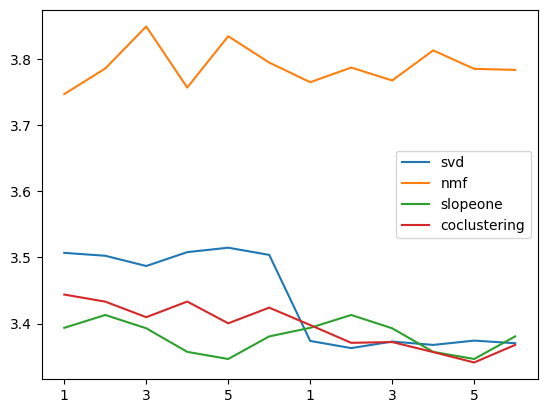

In [ ]:
combine.plot.line()

#get best_svd prediction put into recommender

In [ ]:
grid_search=GridSearchCV(SVD,param_grid=parameters,measures=["rmse"],cv=5)
grid_search.fit(data)
best_params = grid_search.best_params['rmse']
# display(grid_search.best_score,grid_search.best_params)
best_model=SVD(**best_params)
trainset, testset = train_test_split(data, test_size=0.2,random_state=42)
best_predictions=best_model.fit(trainset).test(testset)
best_cv_results = cross_validate(best_model, data, measures=['RMSE'], cv=5, verbose=True)
avg_rmse=sum(best_cv_results['test_rmse']) / len(best_cv_results['test_rmse'])
print( "Average RMSE:",avg_rmse)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.3399  3.3197  3.3543  3.3639  3.3752  3.3506  0.0193  
Fit time          0.32    0.34    0.36    0.35    0.35    0.34    0.01    
Test time         0.10    0.13    0.09    0.41    0.09    0.16    0.12    
Average RMSE: 3.350604553945865


In [ ]:
accuracy.rmse(best_predictions,verbose=True)

RMSE: 3.3530


3.3530008598363588

# SURPRISE algorithms--recommender(svd)

In [352]:
# Generate predictions with svd_best model (svd model with hyperparameter tuning )
user_ids = new_ratings['user_id'].unique()
book_ids = new_ratings['book_id'].unique()
predictions = []
svd_best_pred=svd_best.test(testset)
for user_id in user_ids:
    for book_id in book_ids:
        predictions.append([user_id, book_id, svd_best.predict(user_id, book_id).est])

# Convert to DataFrame
predictions_df = pd.DataFrame(predictions, columns=['user_id', 'book_id', 'predicted_rating'])

In [355]:
def recommend_books(book_title, predictions_df, original_ratings, num_recommendations=5):
    # Find book ID from the title
    book_id = book_title_mapping.get(book_title)

    # Find top users who liked this book
    top_users = predictions_df[predictions_df['book_id'] == book_id].sort_values(by='predicted_rating', ascending=False).head(num_recommendations)['user_id']

    # Find other books liked by these users
    recommended_books = predictions_df[predictions_df['user_id'].isin(top_users) & (predictions_df['book_id'] != book_id)]

    # Aggregate and sort by average rating
    recommended_books = recommended_books.groupby('book_id').agg({'predicted_rating':'mean'}).reset_index()
    recommended_books = recommended_books.sort_values(by='predicted_rating', ascending=False).head(num_recommendations)

    # Map back to book titles
    recommended_books['book_title'] = recommended_books['book_id'].map({v: k for k, v in book_title_mapping.items()})

    return recommended_books[['book_title', 'predicted_rating']]


book_to_recommend = "The Kitchen God's Wife"
# book_to_recommend='The Catcher in the Rye'
recommended_books = recommend_books(book_to_recommend, predictions_df, new_ratings)

recommended_books

,book_title,predicted_rating
152,The Little Prince,9.737517
133,Harry Potter and the Sorcerer's Stone (Book 1),9.378928
116,Harry Potter and the Goblet of Fire (Book 4),9.304680
432,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),9.236457
115,Harry Potter and the Prisoner of Azkaban (Book 3),9.091307


#SURPRISE_NCF recommender